In [ ]:
!pip install --user -U nltk
!python -m nltk.downloader popular

In [ ]:
import pandas as pd
import numpy as np
import re
import collections

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm

from scipy.sparse import coo_matrix, hstack

from nltk.text import Text
from nltk.corpus import stopwords 
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold, KFold, LeaveOneOut
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss, roc_curve, RocCurveDisplay
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE

import xgboost as xgb


# Introduction


Myers-Briggs Type Indicator (MBTI) is a personality test that aims to classify people by personality types. Each person is assigned a dominant function from the following categories; <br>

Introversion/Extroversion, Sensing/Intuition, Thinking/Feeling, Judging/Perceiving. <br>

The tested person is then assigned a letter of the dominant function from each category, thus forming one of 16 personality types such as “ENTP”, “INFP”, “ESTP”.

More on MBTI: https://www.themyersbriggs.com/en-US/Products-and-Services/Myers-Briggs

Even though MBTI is widely used in business and universities, there is a lack of experimental results supporting the validity of the indicator. The aim of this project is to use ML to evaluate the validity of MBTI by creating an ML classification pipeline to predict people’s personality types based on their online posts and writing style.

# Hypothesis

The main aim is to see if ML can be used to accurately classify people by their respective MBTI type based on their online writing style, therefore partially checking the validity of the test.<br>

**Null Hypothesis:** There is no meaningful relationship between MBTI personality type and online behavior (eg comments, posts, etc).<br>

**Alternative Hypothesis:** There is a meaningful relationship between MBTI personality type and online behavior (eg comments, posts, etc).<br>

To prove the validity of the MBTI test, we must reject the null hypothesis. 

# Exploratory Data Analysis

This dataset was obtained from Kaggle and contains over 8600 rows of data, on each row is a person’s:

1.   MBTI type
2.   A section of each of the last 50 things they have posted (Each entry separated by "|||" (3 pipe characters))

The data is originally from the Personality Cafe forum - a forum where people label themselves by MBTI type and engage in discussions.

In [ ]:
df = pd.read_csv('./mbti_1.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


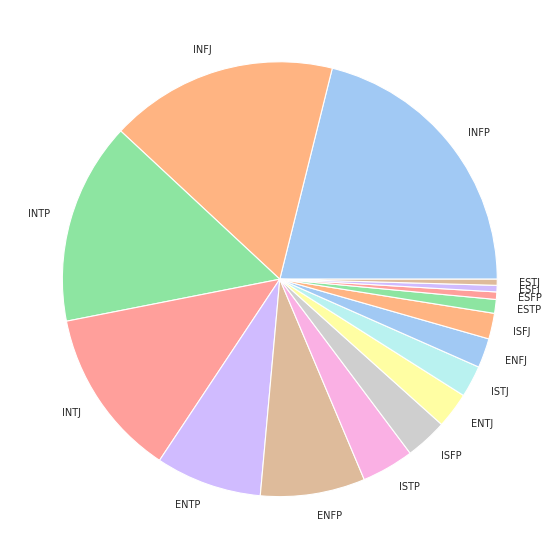

In [ ]:
ctypes = df['type'].value_counts()
colors = sns.color_palette('pastel')
sns.set_theme(palette="pastel", font_scale= 0.8)

figure(figsize=(9, 9), dpi=80)
plt.pie(ctypes.values, labels=ctypes.index)
plt.show()

From the pie chart above, we can see that personality types are not equally represented in the dataset. This resulted low accuracy scores for the underrepresented types in the initial classification attempt, therefore decreasing the overall accuracy of the model. <br>

Ideally, more data should be collected for the underrepresented types, however this is not feasible given the limited timeline of this project. <br>

A more reasonable solution is to split the data by dominant functions rather than the full personality type. For example, rather than classifying by full personality type, we will predict if a person is an Introvert or Extrovert.



In [ ]:
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
df['I'] = None
df['N'] = None
df['T'] = None
df['J'] = None

In [ ]:
for row in range(df.shape[0]):
  i, n, t, j = df.iloc[row]['type'][0], df.iloc[row]['type'][1], df.iloc[row]['type'][2], df.iloc[row]['type'][3]

  if i == 'I':
    df['I'][row] = 1
  else:
    df['I'][row] = 0

  if n == 'N':
    df['N'][row] = 1
  else:
    df['N'][row] = 0

  if t == 'T':
    df['T'][row] = 1
  else:
    df['T'][row] = 0

  if j == 'J':
    df['J'][row] = 1
  else:
    df['J'][row] = 0



In [ ]:
I = df[df['I']==1].count()[0]
E = df.shape[0] - I
N = df[df['N']==1].count()[0]
S = df.shape[0] - N
T = df[df['T']==1].count()[0]
F = df.shape[0] - T
J = df[df['J']==1].count()[0]
P = df.shape[0] - J

Below we will plot the distibution of each persoinality function.

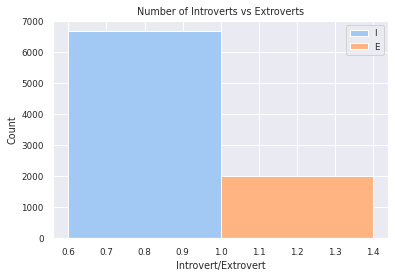

In [ ]:
plt.bar(1 - 0.2, I, 0.4, label = 'I')
plt.bar(1 + 0.2, E, 0.4, label = 'E')

plt.ylabel("Count")
plt.xlabel("Introvert/Extrovert")
plt.title("Number of Introverts vs Extroverts")
plt.legend()
plt.show()

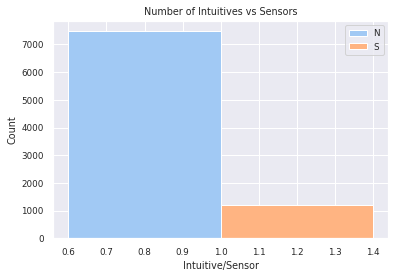

In [ ]:
plt.bar(1 - 0.2, N, 0.4, label = 'N')
plt.bar(1 + 0.2, S, 0.4, label = 'S')

plt.ylabel("Count")
plt.xlabel("Intuitive/Sensor")
plt.title("Number of Intuitives vs Sensors")
plt.legend()
plt.show()

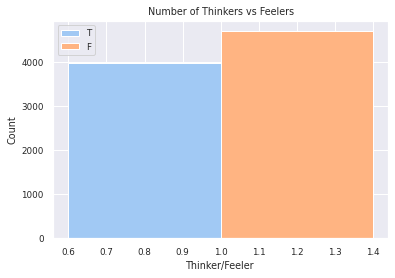

In [ ]:
plt.bar(1 - 0.2, T, 0.4, label = 'T')
plt.bar(1 + 0.2, F, 0.4, label = 'F')

plt.ylabel("Count")
plt.xlabel("Thinker/Feeler")
plt.title("Number of Thinkers vs Feelers")
plt.legend()
plt.show()

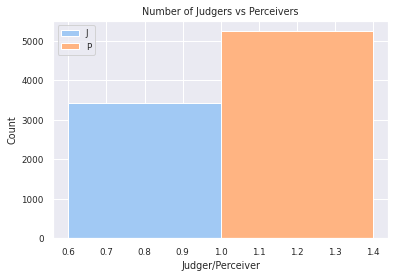

In [ ]:
plt.bar(1 - 0.2, J, 0.4, label = 'J')
plt.bar(1 + 0.2, P, 0.4, label = 'P')

plt.ylabel("Count")
plt.xlabel("Judger/Perceiver")
plt.title("Number of Judgers vs Perceivers")
plt.legend()
plt.show()

From the charts above, we can see when data is sorted by dominant function, the distribution is still uneven, especially for Introversion/Extroversion and Sensing/Feeling. 

The distribution is the closest to 50/50 for the Thinking/Feeling functions. **As a result, T/F are the two classes that will be predicted for the purpose of this project.**


The main predictor used for classification is a text embedding. An example is shown below. Each embedding contains the last 50 posts that the perosn in the dataset made. 

In [ ]:
df.iloc[0]['type'], df.iloc[0]['posts']

('INFJ',
 "'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-desi

**Additional Features**

The correlation between the text embedding and personality type will be difficult to visualize. It may be useful to extract additional predictors: words per comment, links per comment, exclamation marks per comments, and variance of word in a comment. <br>

These predictors may provide useful insight since Thinking and Feeling types may have different posting styles, eg, maybe Feelers are more verbose than Thinkers.


In [ ]:
df['words_per_comm'] = df['posts'].apply(lambda x: len(x.split())/50)
df['links_per_comm'] = df['posts'].apply(lambda x: x.count('http')/50)
df['ex_per_comm'] = df['posts'].apply(lambda x: x.count('!')/50)

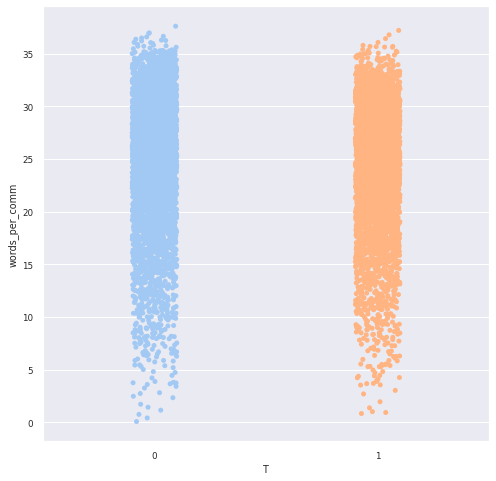

In [ ]:
plt.figure(figsize=(8,8))
sns.stripplot(x="T", y="words_per_comm", data=df)

From the figure above, we can see that there is no significant difference between word count for Thinkers vs Feelers.

In [ ]:
print(df.groupby('T').agg({'links_per_comm': 'mean'}))
print(df.groupby('T').agg({'ex_per_comm': 'mean'}))

   links_per_comm
T                
0        0.067887
1        0.063969
   ex_per_comm
T             
0     0.213230
1     0.117036


The mean number of links per comment is slightly larger for Thinkers than Feelers, however not by a significant amount.<br>

Average exclamation marks per comment is higher for Feelers than Thinkers, so this predictor may provide a useful insight. <br>

Next, the word variance will be extracted.



In [ ]:
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

df['var_of_words'] = df['posts'].apply(lambda x: var_row(x))

In [ ]:
df.head()

,type,posts,I,N,T,J,words_per_comm,links_per_comm,ex_per_comm,var_of_words
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1,11.12,0.48,0.06,135.2900
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0,23.40,0.20,0.00,187.4756
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0,16.72,0.10,0.08,180.6900
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1,21.28,0.04,0.06,181.8324
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1,19.34,0.12,0.02,196.4576


In [ ]:
print(df.groupby('T').agg({'var_of_words': 'mean'}))

   var_of_words
T              
0    137.368287
1    137.023067


**Pair-plot**

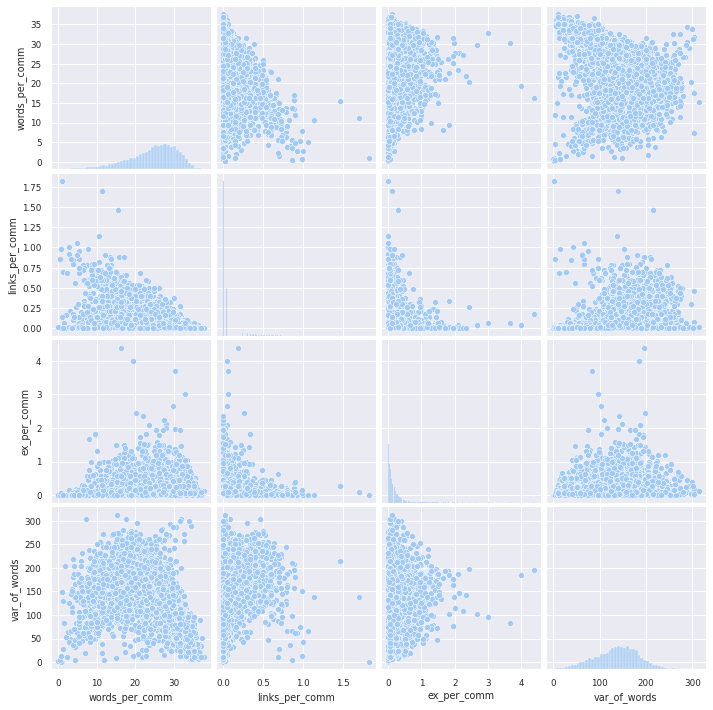

In [ ]:
sns.pairplot(df[['words_per_comm', 'links_per_comm', 'ex_per_comm', 'var_of_words']])

From the pairplot above, we can see that there is no strong linear relationship between the extracted predictors. The pairplot cannot be used to evaluate the relationship of all predictors with response (Thinker/Feeler), since this is a classification problem and the response is quantitative.<br>

In addition, no multicollinearity is detected from the pairplot.

**Correlation Matrix**

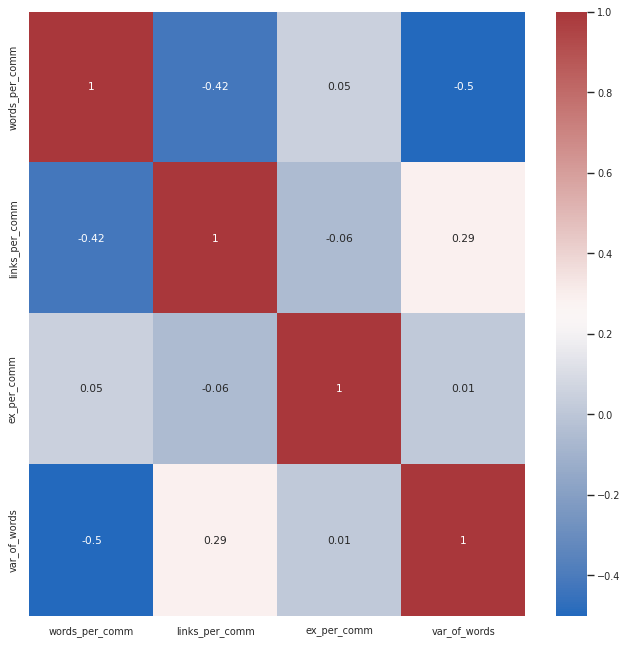

In [ ]:
corrmatrix = df[['words_per_comm', 'links_per_comm', 'ex_per_comm', 'var_of_words']].corr().round(2)
figure(figsize=(10, 10), dpi=80)
sns.heatmap(corrmatrix, annot=True, cmap='vlag')
plt.show()

Just like the pair-plot above, correlation matrix does not show a strong linear relationship between any of the variables. There does not seem to be multicollinearity in the model.

# Pre-Processing

The main predictor for this classification problem is the text. The text has to be vectorized prior to fitting a classification model.

The function below performs the following:


*   Removes separator '| | |' between comments to convert the text into a single post.
*   Removes links and replaces them with a dummy word "link".
*   Removes all symbols that aren't letters including extra spaces. 
*   **Lemmatizes words.** The purpose of lemmatization is to reduce all words to their base form. For example:
    * the boy's cars are different colors --> the boy car be differ color
* Removes stop words, for example, "a, the, on", etc





In [ ]:
def process_text(df):

  lemmatiser = WordNetLemmatizer()

  sw = stopwords.words("english")

  for row in tqdm(range(df.shape[0])):

    post = df.posts[row]
    urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', post)
    proc_post = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'link', post) # TODO: link -> specific link, capitalize links
    proc_post = re.sub("[^a-zA-Z]", " ", proc_post) # remove all symbols other than letters
    proc_post = re.sub(" +", " ", proc_post) # remove spaces

    proc_post = " ".join([lemmatiser.lemmatize(w) for w in proc_post.split(' ') if w not in sw])

    df.at[row,'posts'] = proc_post

    # df.iloc[row]["posts"] = proc_post
    # df.iloc[row]["type"] = types_encoded[row]

In [ ]:
process_text(df)

100%|██████████| 8675/8675 [01:19<00:00, 109.66it/s]


An example of a processed post is shown below. Text will be vectorized during classification.

In [ ]:
df.iloc[0].posts # lemmatizer 

' link link enfp intj moment link sportscenter top ten play link prank What life changing experience life link link On repeat today May PerC Experience immerse The last thing INFJ friend posted facebook committing suicide next day Rest peace link Hello ENFJ Sorry hear distress It natural relationship perfection time every moment existence Try figure hard time time growth link link Welcome stuff link Game Set Match Prozac wellbrutin least thirty minute moving leg I mean moving sitting desk chair weed moderation maybe try edible healthier alternative Basically come three item determined type whichever type want would likely use given type cognitive function whatnot left All thing moderation Sims indeed video game good one Note good one somewhat subjective I completely promoting death given Sim Dear ENFP What favorite video game growing current favorite video game cool link It appears late sad There someone everyone Wait I thought confidence good thing I cherish time solitude b c revel wi

# Classification


**Classes**

Thinker -> 1 <br>
Feeler -> 0

In [ ]:
X = df[['posts', 'words_per_comm','links_per_comm', 'ex_per_comm','var_of_words']]
y = df['T']
y = y.astype('int')

Vectorize text - Initialize Vectorizer

In [ ]:
countvectorizer = CountVectorizer(analyzer='word',
                                  max_features=1500,
                                  stop_words=None
                                  )

tfidftransform = TfidfTransformer()

**Cross-Validation**<br>
LOOCV and K-fold CV will be used for each classifier. 

For k-fold cv, value of k = 10 will be used. This parameter was selected because it provides a good tradeoff between training time and model performance.

In [ ]:
loocv = LeaveOneOut()
loocv.get_n_splits(X)

kcv = KFold(n_splits=10, random_state=42, shuffle=True)
kcv.get_n_splits(X)

10

## Logistic Regression

Since this is a Classification problem, Logistic Regression will be fitted instead of Linear Regression.

In [ ]:
logit = LogisticRegression(max_iter=3000, C=0.5, n_jobs=-1)

### LOOCV


*Note: for LOOCV, text vectorization is required at every iteration. Since there are almost 9000 rows of data, with 7-10s per iteration, LOOCV is very computationally expensive. This was not taken into account initially, so the presented results were obtained from a limited number of iterations.*



In [ ]:
y_loocv = y.to_numpy()

In [ ]:
y_true = []
y_pred = []

for train_ix, test_ix in tqdm(loocv.split(X)):
  # Count vectorizer
  X_train_cnt = countvectorizer.fit_transform(X.posts[train_ix])
  X_test_cnt = countvectorizer.transform(X.posts[test_ix])

  # Tf-idf
  X_train_tfidf = tfidftransform.fit_transform(X_train_cnt)
  X_test_tfidf = tfidftransform.transform(X_test_cnt)

  # Convert additional features to CSR (Sparse Matrix) format
  X_train_wc = coo_matrix(X.words_per_comm[train_ix].to_numpy().reshape(-1, 1))
  X_test_wc = coo_matrix(X.words_per_comm[test_ix].to_numpy().reshape(-1, 1))

  X_train_lc = coo_matrix(X.links_per_comm[train_ix].to_numpy().reshape(-1, 1))
  X_test_lc = coo_matrix(X.links_per_comm[test_ix].to_numpy().reshape(-1, 1))

  X_train_ex = coo_matrix(X.ex_per_comm[train_ix].to_numpy().reshape(-1, 1))
  X_test_ex = coo_matrix(X.ex_per_comm[test_ix].to_numpy().reshape(-1, 1))
  
  X_train_vw = coo_matrix(X.var_of_words[train_ix].to_numpy().reshape(-1, 1))
  X_test_vw = coo_matrix(X.var_of_words[test_ix].to_numpy().reshape(-1, 1))

  # Stack sparse matrices
  X_train = hstack([X_train_tfidf, X_train_wc, X_train_lc, X_train_ex, X_train_vw])
  X_test = hstack([X_test_tfidf, X_test_wc, X_test_lc, X_test_ex, X_test_vw])
  y_train, y_test = y_loocv[train_ix], y_loocv[test_ix]

  logit_fit = logit.fit(X_train_tfidf, y_train)

  y_pred_logit = logit_fit.predict(X_test_tfidf)

  y_true.append(y_test[0])
  y_pred.append(y_pred_logit[0])

In [ ]:
y_true_logit_loocv = np.array(y_true)
y_pred_logit_loocv = np.array(y_pred)

LOOCV Accuracy score from ~6500 iterations: **0.8621**


### K-fold CV

In [ ]:
best_acc_logit_kcv = 0
best_model_logit_kcv = None
best_test_index = None

for train_index, test_index in tqdm(kcv.split(X)):
 
  # Count vectorizer
  X_train_cnt = countvectorizer.fit_transform(X.posts[train_index])
  X_test_cnt = countvectorizer.transform(X.posts[test_index])
  # Tf-idf
  X_train_tfidf = tfidftransform.fit_transform(X_train_cnt)
  X_test_tfidf = tfidftransform.transform(X_test_cnt)

  # Convert additional features to CSR (Sparse Matrix) format
  X_train_wc = coo_matrix(X.words_per_comm[train_index].to_numpy().reshape(-1, 1))
  X_test_wc = coo_matrix(X.words_per_comm[test_index].to_numpy().reshape(-1, 1))

  X_train_lc = coo_matrix(X.links_per_comm[train_index].to_numpy().reshape(-1, 1))
  X_test_lc = coo_matrix(X.links_per_comm[test_index].to_numpy().reshape(-1, 1))

  X_train_ex = coo_matrix(X.ex_per_comm[train_index].to_numpy().reshape(-1, 1))
  X_test_ex = coo_matrix(X.ex_per_comm[test_index].to_numpy().reshape(-1, 1))
  
  X_train_vw = coo_matrix(X.var_of_words[train_index].to_numpy().reshape(-1, 1))
  X_test_vw = coo_matrix(X.var_of_words[test_index].to_numpy().reshape(-1, 1))

  # Stack sparse matrices
  X_train = hstack([X_train_tfidf, X_train_wc, X_train_lc, X_train_ex, X_train_vw])
  X_test = hstack([X_test_tfidf, X_test_wc, X_test_lc, X_test_ex, X_test_vw])
  y_train, y_test = y[train_index], y[test_index]

  logit_fit = logit.fit(X_train, y_train)

  y_pred = logit_fit.predict(X_test)

  acc = accuracy_score(y_test, y_pred)
  if acc > best_acc_logit_kcv:
    best_acc_logit_kcv = acc
    best_model_logit_kcv = logit_fit
    y_true = y_test
    y_pred_logit_kcv = y_pred

    X_test_best, X_train_best = X_test, X_train
    y_test_best, y_train_best = y_test, y_train

10it [02:01, 12.11s/it]


In [ ]:
print("Best Accuracy Score: ", "{:.4f}".format(best_acc_logit_kcv))

Best Accuracy Score:  0.8835


For the testing completed within the project, k-fold CV performs better than LOOCV. In addition the runtime of k-fold CV is much lower. 

### Diagnostics

Logistic Regression Diagnostics will be completed using the K-fold CV predicted values.

**Confusion Matrix**<br>

From confusion matrix below:<br>
TP - 367<br>
TN - 399<br>
FP - 57<br>
FN - 44<br>

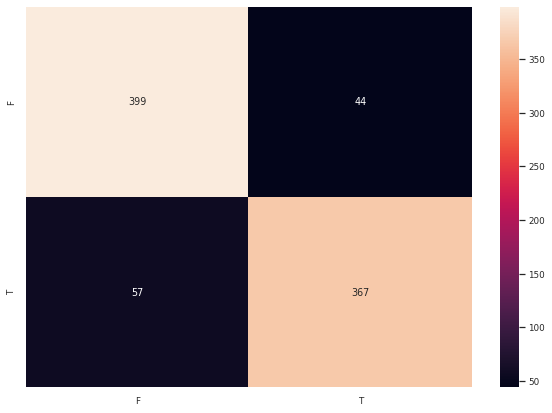

In [ ]:
cm = confusion_matrix(y_true, y_pred_logit_kcv)
# figure(figsize=(8,8))
df_cm = pd.DataFrame(cm, index = [i for i in "FT"],
                  columns = [i for i in "FT"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

**Precision, recall, f1-score, accuracy**

In [ ]:
print('Logistic Regression Classification Report')
print(classification_report(y_pred_logit_kcv, y_true, zero_division=0))

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       456
           1       0.87      0.89      0.88       411

    accuracy                           0.88       867
   macro avg       0.88      0.88      0.88       867
weighted avg       0.88      0.88      0.88       867



**Negative Log Likelihood**

In [ ]:
y_prob = best_model_logit_kcv.predict_proba(X_test)
log_loss(y_test, y_prob)

0.3825850113654767

**Chi-Squared Goodness of fit test**


Chi-squared test measures dependence between stochastic variables, therefore ruling out variables that may be not statistically significant for classification.

In [ ]:
(chi2stats, pvals) = chi2(X_test_best, y_true)

In [ ]:
chi2stats

array([5.04313417e-02, 1.07848113e-03, 1.86900172e-05, ...,
       5.65245620e-02, 1.53248576e+01, 1.44898104e+01])

It is useful to examine p-values to see which predictors are statistically significant. Individual text features will not likely show statistical significance, so more attention will be given to the additional non-text features (index 1500 - 15003)

In [ ]:
ind = []
for i in range(len(pvals)):
  if abs(pvals[i]) < 0.05:
    ind.append(i)
ind

[416, 676, 679, 680, 698, 700, 1500, 1502, 1503]

We can see from the list above that "links per comment" (index 1501) is not statistically significant (p < 0.05).<br>
In a later section, non significant features will be removed.

**ROC Curve**

The classification accuracy is quite high and the ROC curve is of a desirable shape.

<Figure size 720x504 with 0 Axes>

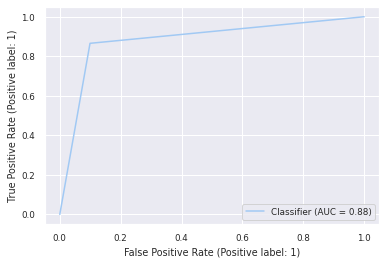

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_logit_kcv)
RocCurveDisplay.from_predictions(y_true, y_pred_logit_kcv)

In [ ]:
print("Best Accuracy Score: ", "{:.4f}".format(best_acc_logit_kcv))

Best Accuracy Score:  0.8835


## Support Vector Classifier

Prior to training the SVC, non-text data must be scaled.

In [ ]:
scaler = StandardScaler()
svc = SVC(gamma='auto')

To speed up training, k=5 folds will be used for SVC.

In [ ]:
kcv = KFold(n_splits=5, random_state=42, shuffle=True)
kcv.get_n_splits(X)

5

In [ ]:
best_acc_svc_kcv = 0
best_model_svc_kcv = None
best_test_index = None

for train_index, test_index in tqdm(kcv.split(X)):
 
  # Count vectorizer
  X_train_cnt = countvectorizer.fit_transform(X.posts[train_index])
  X_test_cnt = countvectorizer.transform(X.posts[test_index])
  # Tf-idf
  X_train_tfidf = tfidftransform.fit_transform(X_train_cnt)
  X_test_tfidf = tfidftransform.transform(X_test_cnt)

  # Convert additional features to CSR (Sparse Matrix) format

  X_train_wc = coo_matrix(scaler.fit_transform(X.words_per_comm[train_index].to_numpy().reshape(-1, 1)))
  X_test_wc = coo_matrix(scaler.fit_transform(X.words_per_comm[test_index].to_numpy().reshape(-1, 1)))

  X_train_lc = coo_matrix(scaler.fit_transform(X.links_per_comm[train_index].to_numpy().reshape(-1, 1)))
  X_test_lc = coo_matrix(scaler.fit_transform(X.links_per_comm[test_index].to_numpy().reshape(-1, 1)))

  X_train_ex = coo_matrix(scaler.fit_transform(X.ex_per_comm[train_index].to_numpy().reshape(-1, 1)))
  X_test_ex = coo_matrix(scaler.fit_transform(X.ex_per_comm[test_index].to_numpy().reshape(-1, 1)))
  
  X_train_vw = coo_matrix(scaler.fit_transform(X.var_of_words[train_index].to_numpy().reshape(-1, 1)))
  X_test_vw = coo_matrix(scaler.fit_transform(X.var_of_words[test_index].to_numpy().reshape(-1, 1)))

  # Stack sparse matrices
  X_train = hstack([X_train_tfidf, X_train_wc, X_train_lc, X_train_ex, X_train_vw])
  X_test = hstack([X_test_tfidf, X_test_wc, X_test_lc, X_test_ex, X_test_vw])
  y_train, y_test = y[train_index], y[test_index]

  svc_fit = svc.fit(X_train, y_train)

  y_pred = svc_fit.predict(X_test)

  acc = accuracy_score(y_test, y_pred)
  if acc > best_acc_svc_kcv:
    best_acc_svc_kcv = acc
    best_model_svc_kcv = svc_fit
    y_true = y_test
    y_pred_svc_kcv = y_pred

    X_test_best_svc, X_train_best_svc = X_test, X_train
    y_test_best_svc, y_train_best_svc = y_test, y_train

5it [19:06, 229.34s/it]


In [ ]:
print("Best Accuracy Score: ", "{:.4f}".format(best_acc_svc_kcv))

Best Accuracy Score:  0.5833


The SVM classifier performs poorly as seen from the accuracy score above. For information, some diagnostics have been comopleted below.

Confusion Matrix

From confusion matrix below:<br>
TP - 128<br>
TN - 884<br>
FP - 646<br>
FN - 77<br>

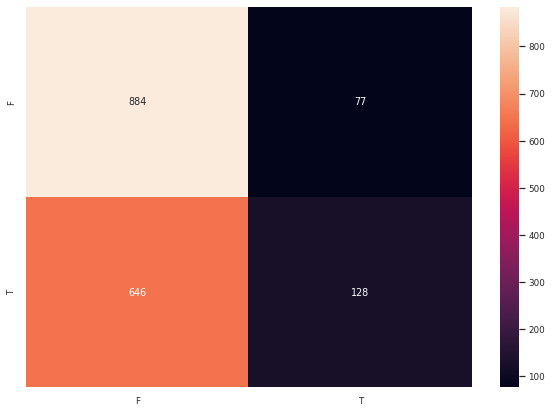

In [ ]:
cm = confusion_matrix(y_true, y_pred_svc_kcv)
# figure(figsize=(8,8))
df_cm = pd.DataFrame(cm, index = [i for i in "FT"],
                  columns = [i for i in "FT"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

The SVC classifier is good at predicting Negatives (Feelers) and very bad at Positives (Thinkers). The classifier may require further data pre-processing or just does not work well for the task.

In [ ]:
print(classification_report(y_pred_svc_kcv, y_true, zero_division=0))

              precision    recall  f1-score   support

           0       0.93      0.59      0.72       791
           1       0.12      0.57      0.19        76

    accuracy                           0.59       867
   macro avg       0.53      0.58      0.46       867
weighted avg       0.86      0.59      0.68       867



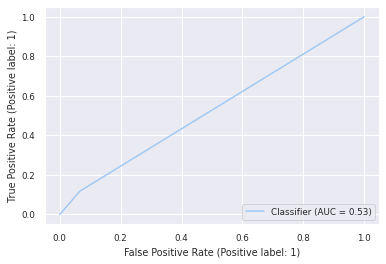

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_svc_kcv)
RocCurveDisplay.from_predictions(y_true, y_pred_svc_kcv)

# Collinearity and Truncated SVD

In the pre-processing section, we found that there is no multicollinearity in the model by examining the scatter plot and correlation matrix.<br>
This can be confirmed by calculating the **Variance Inflation Factor** for the features.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Xp

pd.Series([variance_inflation_factor(Xp.values, i) 
               for i in range(Xp.shape[1])], 
              index=Xp.columns)

words_per_comm    4.591100
links_per_comm    1.502184
ex_per_comm       1.519736
var_of_words      5.430952
dtype: float64

VIF < 10 for the features above which confirms no collinearity for the additional features.

Unlike the non-text features, the text embeddings are more difficult to analyze. However, the embeddings include features that are not statistically significant for classification and model accuracy may improve if they are removed.

Dimensionality reduction can be done to the data, specifically text embeddings, to reduce predictors to principal components and fit logistic regression to those principal components.

In this case, the train and test data is sparse, so we cannot use PCA for dimensionality reduction. Instead, TruncatedSVD will be used. Unlike PCA, Truncated SVD does not center data before computing singular value decomposition, therefore it can be used on sparse data structures.

In [ ]:
svd = TruncatedSVD(n_components=800, random_state=42)
svd.fit(X_test_best)
print(svd.components_)
print(svd.explained_variance_)
print(svd.singular_values_)

In [ ]:
pipe = Pipeline([('svd', svd), ('logit', logit)])
pipe.fit(X_train_best, y_train_best)
test_score = pipe.score(X_test_best, y_test_best)  # Accuracy on test set

In [ ]:
print("Accuracy Score")
print("Logit: ", "{:.4f}".format(best_acc_logit_kcv))
print("Truncated SVD + Logit: ", "{:.4f}".format(test_score))
# print("Logit: ", "{:.4f}".format(best_acc_logit_kcv))

Accuracy Score
Logit:  0.8835
Truncated SVD + Logit:  0.8893


As shown above, Logistic Regression accuracy score is imporved with dimensionality reduction (Truncated SVD).

# Conclusion

T/F Classifier works well. According to the results, people can be quite accurately classified by these two functions from their online posts. This also indicates that natural language may have some meaningful indication to the person's personality type. In that case, maybe MBTI does hold some validity.

However, null hypothesis that was proposed cannot be fully rejected. A model would have to be created that can accurately classify all 16 types based on natural langauge and other features.


## Improvements

*   Obtain more data points and ensure the dataset represents all 16 types equally. <br>
*   Make further improvements to text pre-processing and additional features in the model
*   Explore other classifiers and train an NN if the dataset is sufficiently large.

## Problems

MBTI is inherently inaccurate:
 

*   People rarely fit perfectly into every assigned function and personality type. For example, a person can be 60% Introvert and 40% Extrovert. This variability will be reflected in the data too.
*   Test result may vary. There is an official test, but most tests are unofficial and not controlled. A large number of poeople self-classify, which is encouraged by the creator of MBTI, but overall reduced scientific validity of the test

It is difficult to get good training data:


*   MBTI forums are one of the few places to get data, since people label themselves by personality type. Not ideal, since the types are self classified and forums may be biased towards certain types. 
*   A number of types are underrepresented on the forums (or a lot of people are missclassified).



